In [11]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,\
      MaxPool2D, Conv2D, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint 

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [13]:
x_train = x_train.reshape(x_train.shape[0],28,28,1).astype('float32')
x_test = x_test.reshape(x_test.shape[0],28,28,1).astype('float32')
x_train /= 255
x_test /= 255
y_train = np_utils.to_categorical(y_train) 
y_test = np_utils.to_categorical(y_test)

In [14]:
classifier = Sequential()
classifier.add(Conv2D(32, (3,3), input_shape=(28,28,1)))
BatchNormalization(axis=-1)
classifier.add(Activation('relu'))

classifier.add(Conv2D(32, (3,3)))
BatchNormalization(axis=-1)
classifier.add(Activation('relu'))

classifier.add(MaxPool2D(pool_size=(2,2)))
BatchNormalization(axis=-1)

classifier.add(Conv2D(64, (3,3)))
BatchNormalization(axis=-1)
classifier.add(Activation('relu'))

classifier.add(Conv2D(64, (3,3)))
classifier.add(Activation('relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))

classifier.add(Flatten())
BatchNormalization()

classifier.add(Dense(512))
BatchNormalization()
classifier.add(Activation('relu'))

classifier.add(Dropout(0.2))
classifier.add(Dense(10))
classifier.add(Activation('softmax'))

In [15]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
train_gen = ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.1,
                               shear_range=0.3,
                               height_shift_range=0.1,
                               zoom_range=0.1)
test_gen = ImageDataGenerator()

In [17]:
training_set = train_gen.flow(x_train,y_train,batch_size=200)
test_set = train_gen.flow(x_test,y_test,batch_size=200)

In [18]:
model_save_path = 'straight_bs200e80vs60.h5'
checkpoint_callback = ModelCheckpoint(model_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [19]:
history = classifier.fit_generator(training_set,
                                   steps_per_epoch=60,
                                   validation_data=test_set,
                                   validation_steps=60,
                                   epochs=80,
                                   callbacks=[checkpoint_callback])

Epoch 1/80
60/60 [==============================] - ETA: 0s - loss: 0.9973 - accuracy: 0.6789
Epoch 00001: val_accuracy improved from -inf to 0.89542, saving model to straight_bs200e80vs60.h5
60/60 [==============================] - 9s 155ms/step - loss: 0.9973 - accuracy: 0.6789 - val_loss: 0.3379 - val_accuracy: 0.8954
Epoch 2/80
60/60 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.9140
Epoch 00002: val_accuracy improved from 0.89542 to 0.94925, saving model to straight_bs200e80vs60.h5
60/60 [==============================] - 10s 159ms/step - loss: 0.2718 - accuracy: 0.9140 - val_loss: 0.1646 - val_accuracy: 0.9492
Epoch 3/80
60/60 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.9456
Epoch 00003: val_accuracy improved from 0.94925 to 0.95575, saving model to straight_bs200e80vs60.h5
60/60 [==============================] - 10s 168ms/step - loss: 0.1808 - accuracy: 0.9456 - val_loss: 0.1415 - val_accuracy: 0.9557
Epoch 4/80
60/60 [=====

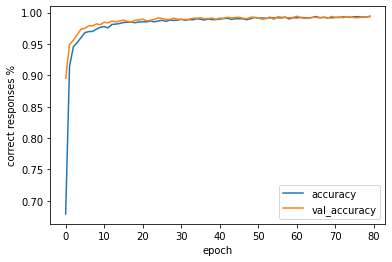

In [20]:
plt.plot(history.history['accuracy'],
         label='accuracy')
plt.plot(history.history['val_accuracy'],
         label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('correct responses %')
plt.legend()
plt.show()